# Text Alignment Pipeline

## 1. Objective

Align two raw texts in different languages and extract as much parallel sentences as possible.
In this particular case there are two texts in Chinese and Russian.

## 2. Pipeline

In [2]:
import pymorphy2
import re
import torch
import seaborn as sns
import numpy as np
import razdel
import os

from scipy import spatial
from matplotlib import pyplot as plt
from transformers import AutoTokenizer, AutoModelWithLMHead

In [11]:
basepath = r"D:\ml\tap"

file_ru = "chekhov_futlar_ru.txt"
file_zh = "chekhov_futlar_zh.txt"

raw_path = os.path.join(basepath, "raw")
splitted_path = os.path.join(basepath, "splitted")
proxy_path = os.path.join(basepath, "proxy")
output_path = os.path.join(basepath, "done")

raw_ru = os.path.join(raw_path, file_ru)
raw_zh = os.path.join(raw_path, file_zh)
splitted_ru = os.path.join(splitted_path, file_ru)
splitted_zh = os.path.join(splitted_path, file_zh)
proxy_ru = os.path.join(proxy_path, file_ru)
output_ru = os.path.join(output_path, file_ru)
output_zh = os.path.join(output_path, file_zh)

if not os.path.exists(basepath):
    os.mkdir(basepath)
    
if not os.path.exists(raw_path):
    os.mkdir(raw_path)
    
if not os.path.exists(splitted_path):
    os.mkdir(splitted_path)
    
if not os.path.exists(proxy_path):
    os.mkdir(proxy_path)
    
if not os.path.exists(output_path):
    os.mkdir(output_path)

### 2.1 Split texts to sentences

#### Russian

In [12]:
#Russian
pattern_ru_orig = re.compile(r'[a-zA-Z\(\)\[\]\/\<\>•\'\n]+')
double_spaces = re.compile(r'[\s]+')
double_commas = re.compile(r'[,]+')
double_dash = re.compile(r'[-—]+')

with open(raw_ru, mode='r', encoding='utf-8') as input_ru, open(splitted_ru, mode='w', encoding='utf-8') as out_ru:
    ru = ' '.join(input_ru.readlines())
    ru = re.sub(pattern_ru_orig, '', ru)
    ru = re.sub(double_spaces, ' ', ru)
    ru = re.sub(double_commas, ',', ru)
    ru = re.sub(double_dash, '—', ru)
    
    sent_ru = list(x.text for x in razdel.sentenize(ru))
    
    count = 1
    for x in sent_ru:
        if count < len(sent_ru)-1:
            out_ru.write(x.strip() + "\n")
        else:
            out_ru.write(x.strip())
        count += 1
            
print(len(sent_ru))

241


In [14]:
sent_ru[:10]

['На самом краю села Мироносицкого, в сарае старосты Прокофия, расположились на ночлег запоздавшие охотники.',
 'Их было только двое: ветеринарный врач Иван Иваныч и учитель гимназии Буркин.',
 'У Ивана Иваныча была довольно странная, двойная фамилия — Чимша—Гималайский, которая совсем не шла ему, и его во всей губернии звали просто по имени и отчеству; он жил около города на конском заводе и приехал теперь на охоту, чтобы подышать чистым воздухом.',
 'Учитель же гимназии Буркин каждое лето гостил у графов П. и в этой местности давно уже был своим человеком.',
 'Не спали.',
 'Иван Иваныч, высокий худощавый старик с длинными усами, сидел снаружи у входа и курил трубку; его освещала луна.',
 'Буркин лежал внутри на сене, и его не было видно в потемках.',
 'Рассказывали разные истории.',
 'Между прочим, говорили о том, что жена старосты, Мавра, женщина здоровая и неглупая, во всю свою жизнь нигде не была дальше своего родного села, никогда не видела ни города, ни железной дороги, а в посл

#### Chinese

In [13]:
#Chinese
pattern_zh = re.compile(r'[」「“”„‟\x1a⓪①②③④⑤⑥⑦⑧⑨⑩⑴⑵⑶⑷⑸⑹⑺⑻⑼⑽*a-zA-Zа-яА-Я\(\)\[\]\s\n\/\-\:•＂＃＄％＆＇（）＊＋－／：；＜＝＞＠［＼］＾＿｀｛｜｝～｟｠｢｣､、〃》【】〔〕〖〗〘〙〜〟〰〾〿–—‘’‛‧﹏〉]+')
pat_comma = re.compile(r'[\.]+')

def split_zh(paragraph):
    for sent in re.findall(u'[^!?。！？\.\!\?]+[!?。！？\.\!\?]?', paragraph, flags=re.U):
        yield sent

with open(raw_zh, mode='r', encoding='utf-8') as input_zh, open(splitted_zh, mode='w', encoding='utf-8') as out_zh:
    zh = ''.join(input_zh.readlines())    
    zh = re.sub(pat_comma, '。', zh)
                       
    sent_zh = list(re.sub(pattern_zh,'',x.strip()) for x in split_zh(zh))

    count = 1
    for x in sent_zh:
        if count < len(sent_zh)-1:
            out_zh.write(x.strip() + "\n")
        else:
            out_zh.write(x.strip())
        count += 1
        
print(len(sent_zh))

311


In [15]:
sent_zh[:10]

['误了时辰的猎人们在米罗诺西茨科耶村边上村长普罗科菲的堆房里住下来过夜了。',
 '他们一共只有两个人兽医伊万伊万内奇和中学教师布尔金。',
 '伊万。',
 '伊万内奇姓一个相当古怪的双姓奇姆沙吉马莱斯基，这个姓跟他一点也不相称，全省的人就简单地叫他的本名和父名伊万伊万内奇。',
 '他住在城郊一个养马场上，这回出来打猎是为了透一透新鲜空气。',
 '然而中学教师布尔金每年夏天都在伯爵家里做客，对这个地区早已熟透了。',
 '他们没睡觉。',
 '伊万伊万内奇是一个又高又瘦的老人，留着挺长的唇髭，这时候坐在门口，脸朝外，吸着烟斗。',
 '月亮照在他身上。',
 '布尔金躺在房里的干草上，在黑暗里谁也看不见他。']

### 2.2 Proxy text 

Proxy text is a **splitted_zh** file machine translated to Russian. Translate it with the Google, Amazon, Bing, Yandex, etc. and **put in the proxy folder**.

In [21]:
#check if proxy file exists
if not(os.path.isfile(proxy_ru)):
    raise Exception("Proxy file not found:", proxy_ru)

print("Proxy file is found:")
print(proxy_ru + "\n")

Proxy file is found:
D:\ml\tap\proxy\chekhov_futlar_ru.txt



### 2.3 Sentences to vectors

In [17]:
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased-sentence")
model = AutoModelWithLMHead.from_pretrained("DeepPavlov/rubert-base-cased-sentence")

def get_sent_vec(text):
    tokenized_text = tokenizer.encode(text, add_special_tokens=True)
    tokens_tensor = torch.tensor(tokenized_text).unsqueeze(0)
    model.eval()
    with torch.no_grad():
        return model(tokens_tensor)[0]

In [18]:
first_numbers = re.compile(r'^[0-9,\.]+')
last_punct = re.compile(r'[,\.]+$')
multiple_spaces = re.compile(r'\s+')
pattern_ru = re.compile(r'[a-zA-Z\.\(\)\[\]\/\-\:!?\<\>;•\"\'«»——,]+')

#lemmatization
morph = pymorphy2.MorphAnalyzer()

def get_file_vectors(path_ru):
    ru_vectors = []
    with open(path_ru, mode="r", encoding="utf-8") as input_ru:
        for line_ru in input_ru.readlines():
            line_ru = re.sub(pattern_ru, '', line_ru).strip()
            line_ru = re.sub(last_punct, '', line_ru).strip()
            line_ru = re.sub(first_numbers, '', line_ru).strip()
            line_ru = re.sub(multiple_spaces, ' ', line_ru).strip()
            line_ru = line_ru.lower()

            line_ru = ' '.join(list(map(lambda x: morph.parse(x)[0].normal_form, line_ru.split())))
            #print(line_ru)
            ru_vectors.append(get_sent_vec(line_ru))
    return ru_vectors

In [22]:
vectors_ru1 = get_file_vectors(proxy_ru)
vectors_ru2 = get_file_vectors(splitted_ru)

### 2.4 Calculate similarity matrix

In [28]:
def get_sim_matrix(ru_vec, ru_vec2, window=10):
    sim_matrix=np.zeros((len(ru_vec), len(ru_vec2)))
    #angle coefficient
    k = len(ru_vec)/len(ru_vec2)
    for i in range(len(ru_vec)):
        for j in range(len(ru_vec2)):
            if (j*k > i-window) & (j*k < i+window):
                sim = 1 - spatial.distance.cosine(ru_vec[i][0,-1,:], ru_vec2[j][0,-1,:])
                sim_matrix[i,j] = sim
    return sim_matrix

In [29]:
sim_matrix = get_sim_matrix(vectors_ru1, vectors_ru2, 12)

### 2.5 Vizualization 

pairs found: 62


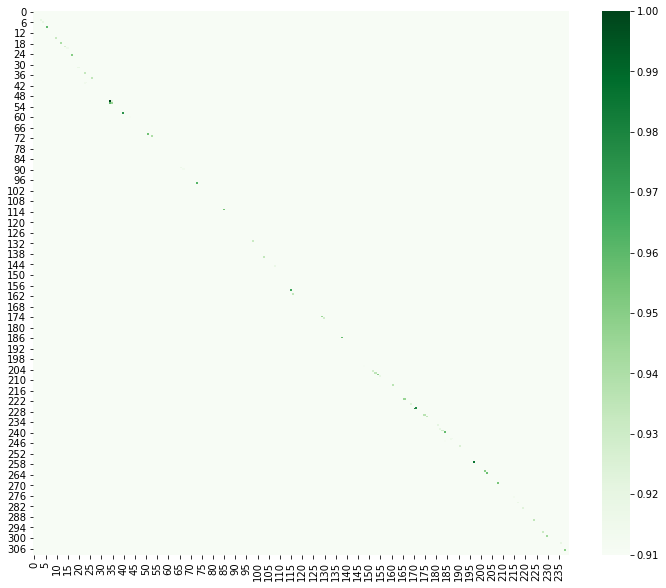

In [61]:
threshold = 0.91

plt.figure(figsize=(12,10))
sns.heatmap(sim_matrix,cmap="Greens", vmin=threshold)

count = 0
for i in range(sim_matrix.shape[0]):
    for j in range(sim_matrix.shape[1]):
        if sim_matrix[i,j] >= threshold:
            count += 1
        
print("pairs found:", count)

### 2.6 Retrieve the parallel pairs

In [49]:
def get_pairs(ru_lines, zh_lines, ru_proxy_lines, sim_matrix, threshold):
    ru = []
    zh = []
    proxy = []
    sims = []
    for i in range(sim_matrix.shape[0]):
        for j in range(sim_matrix.shape[1]):
            if sim_matrix[i,j] >= threshold:
                ru.append(ru_lines[j])
                zh.append(zh_lines[i])
                proxy.append(ru_proxy_lines[i])
                sims.append(sim_matrix[i,j])
    return ru,zh,proxy,sims

In [50]:
with open(splitted_ru, mode="r", encoding="utf-8") as input_ru, \
     open(splitted_zh, mode="r", encoding="utf-8") as input_zh, \
     open(proxy_ru, mode="r", encoding="utf-8") as input_proxy:
    lines_ru = input_ru.readlines()
    lines_zh = input_zh.readlines()
    lines_ru_proxy = input_proxy.readlines()    

res_ru, res_zh, res_ru_proxy, sims = get_pairs(lines_ru, lines_zh, lines_ru_proxy, sim_matrix, threshold)

In [59]:
write_log = True

with open(output_ru, mode="w", encoding="utf-8") as out_ru, \
     open(output_zh, mode="w", encoding="utf-8") as out_zh:
    for ru,zh,pr,sim in zip(res_ru, res_zh, res_ru_proxy, sims):
        out_ru.write(ru)
        out_zh.write(zh)
        print(ru)
        print(zh)    
        if write_log:
            print(f"> proxy [{sim:.4f}]: {pr.strip()}")
            print("----------------------------------------------------------")

Учитель же гимназии Буркин каждое лето гостил у графов П. и в этой местности давно уже был своим человеком.

然而中学教师布尔金每年夏天都在伯爵家里做客，对这个地区早已熟透了。

> proxy [0.9188]: Но Булкин, учитель средней школы, является гостем в доме графа каждое лето, и он уже хорошо знает этот район.
----------------------------------------------------------
Не спали.

他们没睡觉。

> proxy [0.9194]: Они не спали.
----------------------------------------------------------
Буркин лежал внутри на сене, и его не было видно в потемках.

布尔金躺在房里的干草上，在黑暗里谁也看不见他。

> proxy [0.9595]: Буркин лежал на сене в комнате, и никто не мог видеть его в темноте.
----------------------------------------------------------
Быть может, тут явление атавизма, возвращение к тому времени, когда предок человека не был еще общественным животным и жил одиноко в своей берлоге, а может быть, это просто одна из разновидностей человеческого характера,— кто знает?

也许这是隔代遗传的现象，重又退回从前人类祖先还不是群居的动物而是孤零零地住在各自洞穴里的时代的现象，不过，也许这只不过是人类性格的一种类型吧，谁知道呢？

> proxy [0.932